# Garbage Classification using PyTorch

Garbage segregation involves separating wastes according to how it's handled or processed. It's important for recycling as some materials are recyclable and others are not.


![Garbage Bins](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwebstockreview.net%2Fimages%2Fgarbage-clipart-wastebin-16.png&f=1&nofb=1)


In this notebook we'll use PyTorch for classifying trash into various categories like metal, cardboard, etc.

Let us start by importing the libraries:

In [ ]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

Let us see the classes present in the dataset:

In [ ]:
data_dirs = [
    "/kaggle/input/garbage-classification/Garbage classification/Garbage classification",
    "/kaggle/input/gc-databasev1/garbage-dataset"
]
for data_dir in data_dirs:
    if os.path.exists(data_dir):  # Kiểm tra xem thư mục có tồn tại không
        classes = os.listdir(data_dir)
        print(f"Classes in {data_dir}: {classes}")
    else:
        print(f"Path not found: {data_dir}")

    classes = os.listdir(data_dir)
    print(classes)

## Transformations:

Now, let's apply transformations to the dataset and import it for use.

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

Let's create a helper function to see the image and its corresponding label:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

In [ ]:
img, label = dataset[12]
show_sample(img, label)

# Loading and Splitting Data:

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

We'll split the dataset into training, validation and test sets:

In [ ]:
print(f"Total dataset size: {len(dataset)}")


In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [6800, 655, 3300])
len(train_ds), len(val_ds), len(test_ds)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

Now, we'll create training and validation dataloaders using `DataLoader`.

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

This is a helper function to visualize batches:

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

In [ ]:
show_batch(train_dl)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

We'll be using ResNet50 for classifying images:

In [ ]:
!pip install ipywidgets --upgrade
!jupyter nbextension enable --py widgetsnbextension


In [ ]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.mobilenet_v2(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.classifier[1].in_features
        self.network.classifier[1] = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

## Porting to GPU:

GPUs tend to perform faster calculations than CPU. Let's take this advantage and use GPU for computation:

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

# Training the Model:

This is the function for fitting the model.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(ResNet(), device)

In [ ]:
evaluate(model, val_dl)

Let's start training the model:

In [ ]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

# Visualizing Predictions:

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Let us see the model's predictions on the test dataset:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Chuyển mô hình lên GPU
img = img.to(device)  # Chuyển input lên GPU


In [ ]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# Predicting External Images:

In [ ]:
loaded_model = model

This function takes the image's name and prints the predictions:

In [ ]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image_path = Path(image_name)
    
    if not image_path.exists():
        raise FileNotFoundError(f"File {image_name} not found!")

    image = Image.open(image_path)
    example_image = transformations(image)
    
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")

Switch device to CPU

In [ ]:
device = torch.device("cpu")
model.to(device)

Convert model to Onnx format

In [ ]:
import torch.onnx

dummy_input = torch.randn(1, 3, 224, 224)  # Input giả lập với kích thước MobileNetV2

torch.onnx.export(
    model,                      # Mô hình PyTorch
    dummy_input,                 # Dữ liệu đầu vào
    "GC_v5.onnx",                # Tên file đầu ra
    export_params=True,          # Xuất trọng số cùng với mô hình
    opset_version=11,            # Phiên bản ONNX (>=11 là tốt nhất)
    do_constant_folding=True,    # Tối ưu hóa mô hình
    input_names=["input"],       # Tên đầu vào
    output_names=["output"],     # Tên đầu ra
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}  # Hỗ trợ batch size linh hoạt
)

print("Chuyển đổi sang ONNX thành công! ✅")


Update package

In [1]:
!pip install --upgrade numpy
!pip install opencv-python numpy
!pip install ipywidgets --upgrade
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 15.7 MB 5.3 MB/s eta 0:00:01
ERROR: osmnx 0.14.1 has requirement geopandas>=0.7, but you'll have geopandas 0.6.3 which is incompatible.
ERROR: kornia 0.3.1 has requirement torch==1.5.0, but you'll have torch 1.5.1 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.7.0 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement numpy<1.16,>=1.13, but you'll have numpy 1.21.6 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement scikit-learn<0.21,>=0.19.0, but you'll have scikit-learn 0.23.1 which is incompatible.
ERROR: hypertools 0.6.2 has requirement scikit-learn<0.22,>=0.19.1, but you'll have scikit-learn 0.23.1 which is incompatible.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.1
    Uninstalling numpy-1.18.1:
      Successfully uninstalled numpy-1.18.1
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pi

In [6]:
!pip install onnxruntime
import onnxruntime as ort

# Load mô hình ONNX
session = ort.InferenceSession("/kaggle/input/gc_modelv2/pytorch/default/3/GC_v5.onnx")

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


Load test set

In [7]:
import os
root_dir = "/kaggle/input/gc-test4/Data_test"

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Đường dẫn thư mục chính


class_label = {
    "cardboard": 0,
    "glass": 1,
    "metal": 2,
    "paper": 3,
    "plastic": 4,
    "trash": 5
}
# Lấy danh sách các thư mục con (6 thư mục)
sub_dirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

# Danh sách chứa nhãn thật và nhãn dự đoán
y_true = []
y_pred = []

# Duyệt qua từng thư mục con
for sub_dir in sub_dirs:
    folder_name = os.path.basename(sub_dir) 
    sub = class_label.get(folder_name,-1)
    print(f"Processing folder: {sub_dir} {sub}")
    
    # Lấy danh sách tất cả ảnh trong thư mục con
    image_files = [f for f in os.listdir(sub_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
    test_size=0
    true_count=0
    # Duyệt qua từng ảnh
    for image_file in image_files:
        image_path = os.path.join(sub_dir, image_file)
        #print(f"Processing: {image_path}")

        # Đọc ảnh
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error loading image: {image_path}")
            continue  # Bỏ qua nếu ảnh bị lỗi

        # Resize ảnh về 224x224
        image = cv2.resize(image, (224, 224))

        # Chuyển từ BGR sang RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Chuẩn hóa ảnh về dạng tensor
        image = image.astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1))  # Chuyển (H, W, C) -> (C, H, W)
        image = np.expand_dims(image, axis=0)  # Thêm batch dimension (1, C, H, W)

        # Chạy mô hình dự đoán
        inputs = {session.get_inputs()[0].name: image}
        outputs = session.run(None, inputs)

        # Lấy kết quả dự đoán
        predictions = outputs[0]
        predicted_class = np.argmax(predictions, axis=1)[0]

         # Lưu vào danh sách để tạo confusion matrix
        y_true.append(sub)
        y_pred.append(predicted_class)
        
        test_size+=1
        if predicted_class == sub:
            true_count+=1
        sub_image = np.squeeze(image)
        sub_image = np.transpose(sub_image, (1, 2, 0))

Processing folder: /kaggle/input/gc-test4/Data_test/glass 1
Processing folder: /kaggle/input/gc-test4/Data_test/paper 3
Processing folder: /kaggle/input/gc-test4/Data_test/cardboard 0
Processing folder: /kaggle/input/gc-test4/Data_test/plastic 4


Show the result

In [10]:
print(f"Accuracy rate: {true_count/test_size}")

Accuracy rate: 0.7437357630979499


Show confusion matrix

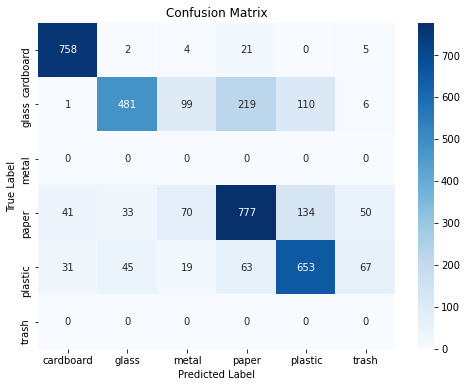

In [11]:
# Tạo confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_label.keys(), yticklabels=class_label.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()